In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
from utils import *
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

if not sys.warnoptions:
    warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('technical_task_dataset.csv')
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn
0,8.0,0.0,38.0,0,4370.0,71.0,5.0,17.0,0
1,0.0,0.0,NaN,0,318.0,5.0,7.0,4.0,0
2,10.0,0.0,37.0,0,2453.0,60.0,359.0,24.0,0
3,10.0,0.0,38.0,0,4198.0,66.0,NaN,35.0,0
4,3.0,0.0,38.0,0,NaN,58.0,NaN,33.0,0


In [3]:
df.shape

(3150, 9)

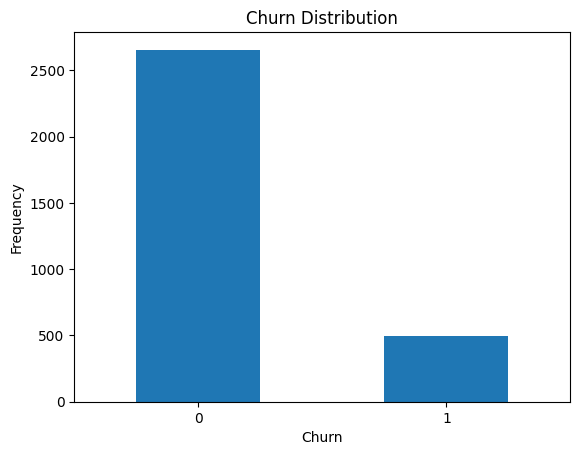

In [4]:
count_classes = pd.value_counts(df['Churn'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Churn Distribution")
plt.xticks(range(2))
plt.xlabel("Churn")
plt.ylabel("Frequency");

In [5]:
df.dtypes

Call Failure               float64
Complains                  float64
Subscription Length        float64
Charge Amount                int64
Seconds of Use             float64
Frequency of use           float64
Frequency of SMS           float64
Distinct Called Numbers    float64
Churn                        int64
dtype: object

In [6]:
df.isna().sum()

Call Failure               626
Complains                  592
Subscription Length        517
Charge Amount                0
Seconds of Use             589
Frequency of use           671
Frequency of SMS           662
Distinct Called Numbers    636
Churn                        0
dtype: int64

In [7]:
df = preprocess(df)

In [8]:
df.isna().sum()

Call Failure               0
Complains                  0
Subscription Length        0
Charge Amount              0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Churn                      0
dtype: int64

In [9]:
df.dtypes

Call Failure               int32
Complains                  int32
Subscription Length        int32
Charge Amount              int32
Seconds of Use             int32
Frequency of use           int32
Frequency of SMS           int32
Distinct Called Numbers    int32
Churn                      int32
dtype: object

In [10]:
nochurn = df[df['Churn']==0]
churn = df[df['Churn']==1]

In [11]:
nochurn.shape

(2655, 9)

In [12]:
churn.shape

(495, 9)

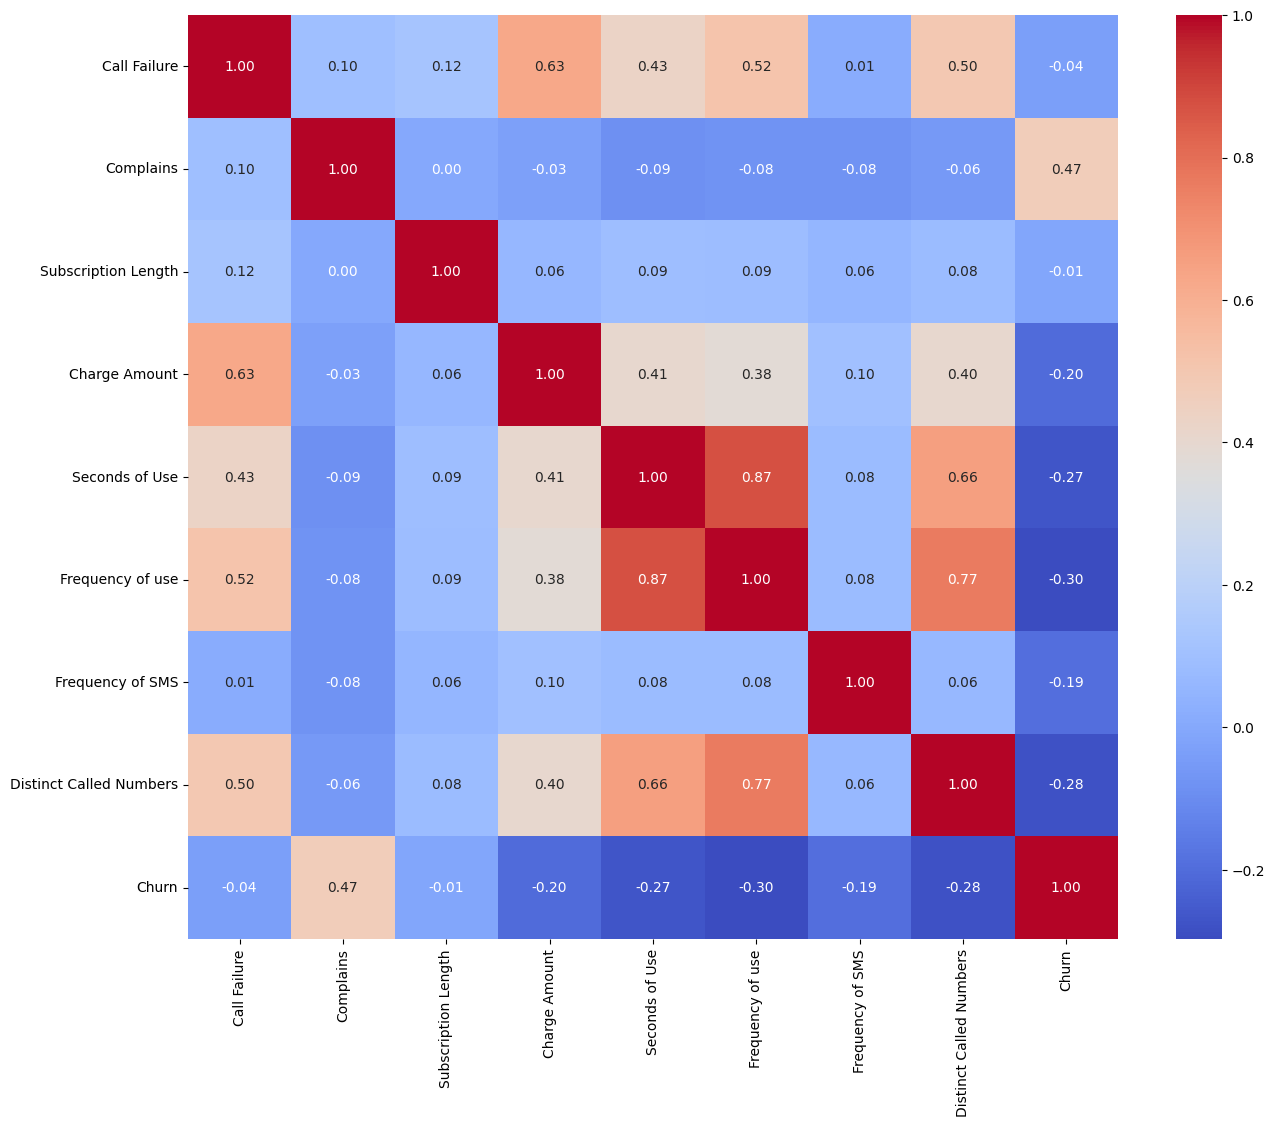

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

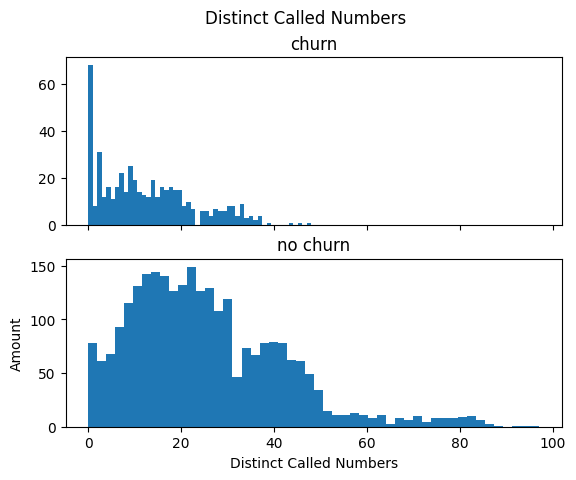

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Distinct Called Numbers')
bins = 50
ax1.hist(churn['Distinct Called Numbers'], bins = bins)
ax1.set_title('churn')
ax2.hist(nochurn['Distinct Called Numbers'], bins = bins)
ax2.set_title('no churn')
plt.xlabel('Distinct Called Numbers')
plt.ylabel('Amount')
plt.show();

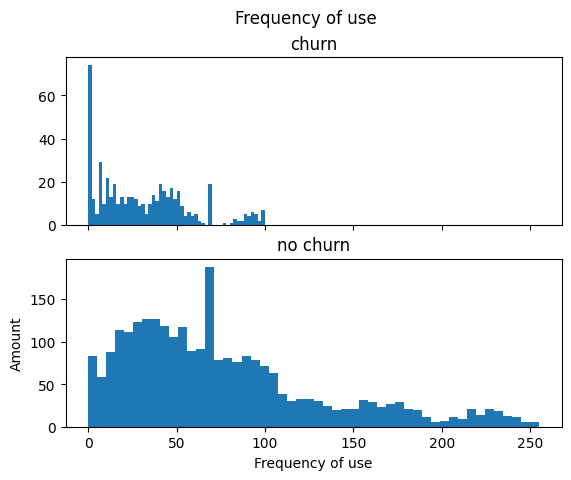

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Frequency of use')
bins = 50
ax1.hist(churn['Frequency of use'], bins = bins)
ax1.set_title('churn')
ax2.hist(nochurn['Frequency of use'], bins = bins)
ax2.set_title('no churn')
plt.xlabel('Frequency of use')
plt.ylabel('Amount')
plt.show();

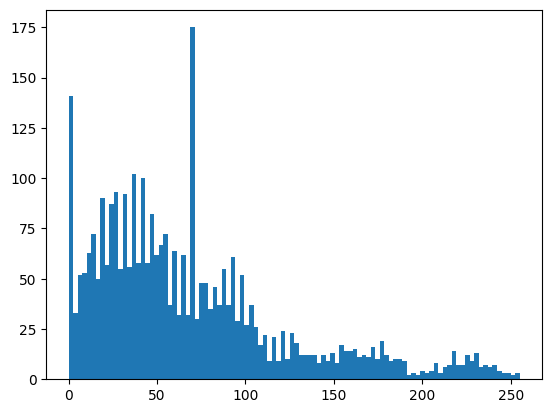

In [16]:
plt.hist(df['Frequency of use'], bins=100);

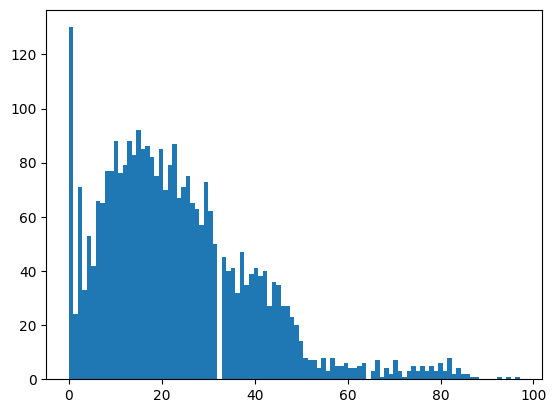

In [17]:
plt.hist(df['Distinct Called Numbers'], bins=100);

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Call Failure             3150 non-null   int32
 1   Complains                3150 non-null   int32
 2   Subscription Length      3150 non-null   int32
 3   Charge Amount            3150 non-null   int32
 4   Seconds of Use           3150 non-null   int32
 5   Frequency of use         3150 non-null   int32
 6   Frequency of SMS         3150 non-null   int32
 7   Distinct Called Numbers  3150 non-null   int32
 8   Churn                    3150 non-null   int32
dtypes: int32(9)
memory usage: 110.9 KB


In [19]:
X = df.values

In [20]:
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

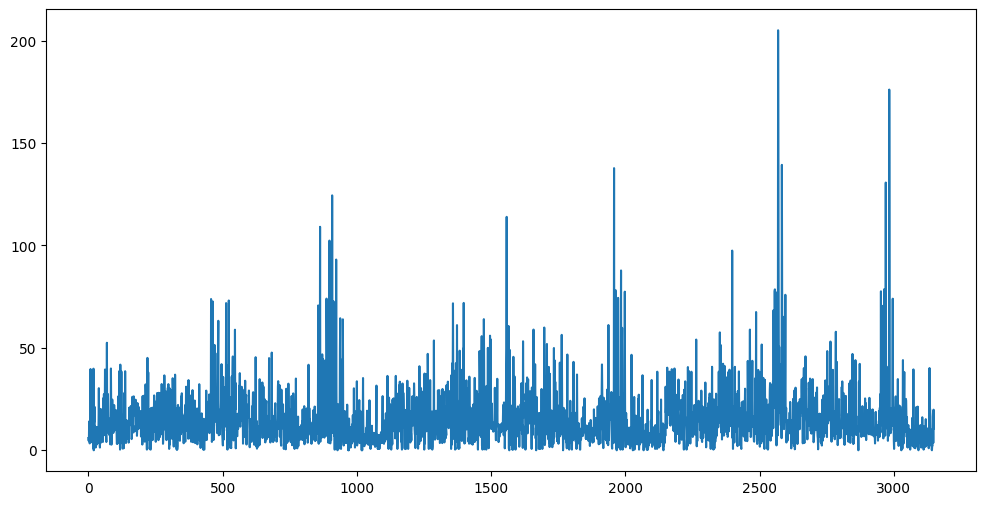

In [21]:
distances, indexes = nbrs.kneighbors(X)
plt.figure(figsize=(12,6))
plt.plot(distances.mean(axis =1))

In [22]:
outlier_index = np.where(distances.mean(axis = 1) > 125)
outlier_index

(array([1958, 2569, 2570, 2583, 2970, 2983], dtype=int64),)

In [23]:
outlier_values = df.iloc[outlier_index]
outlier_values

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn
1958,4,0,32,0,12758,152,0,42,0
2569,14,0,39,3,8413,143,412,60,0
2570,17,0,39,4,12370,170,39,64,0
2583,34,0,33,6,16980,254,28,97,0
2970,14,0,40,3,12480,171,26,49,0
2983,19,0,32,5,17090,255,15,82,0


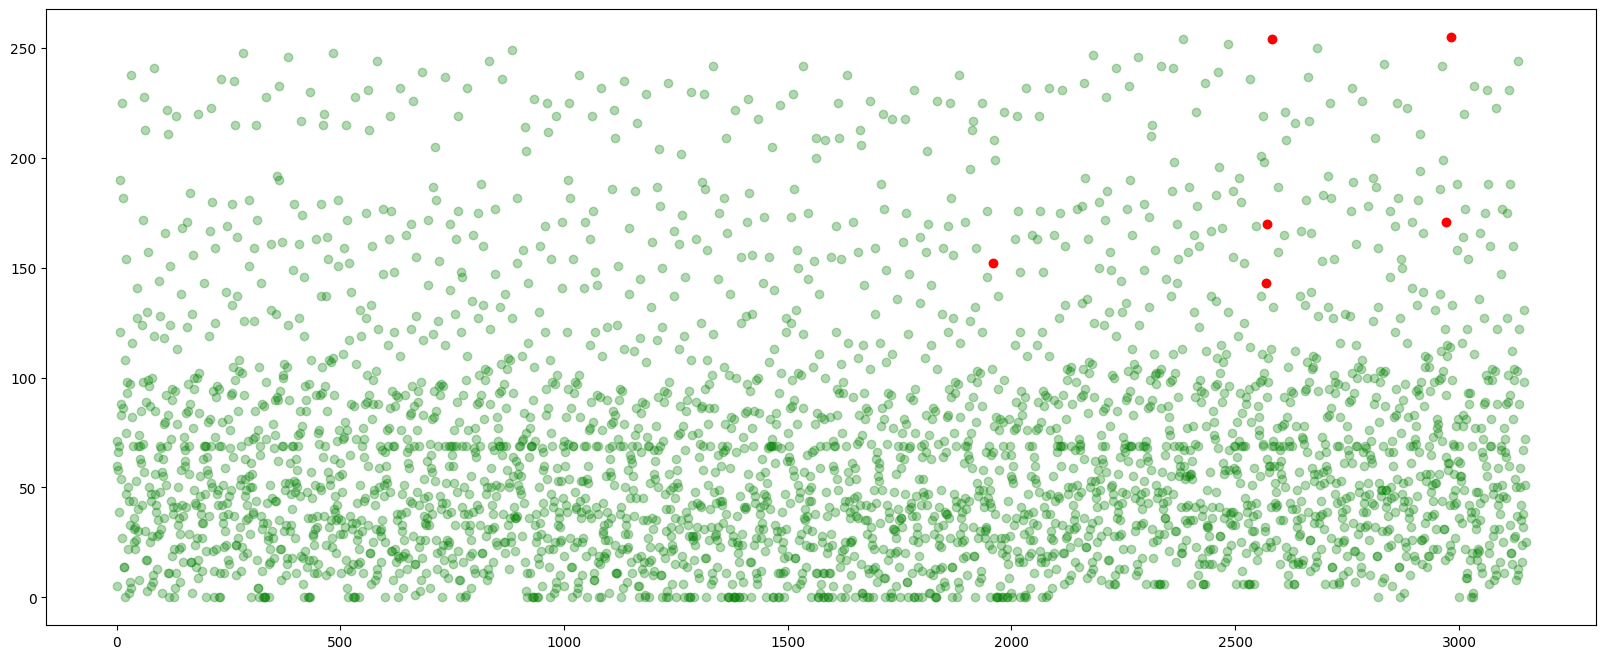

In [24]:
plt.figure(figsize=(20,8))
plt.scatter(df.index,df["Frequency of use"] ,color = "g",alpha=0.3)
otlr_val = df.iloc[outlier_index]
plt.scatter(otlr_val.index,otlr_val["Frequency of use"], color = "r")

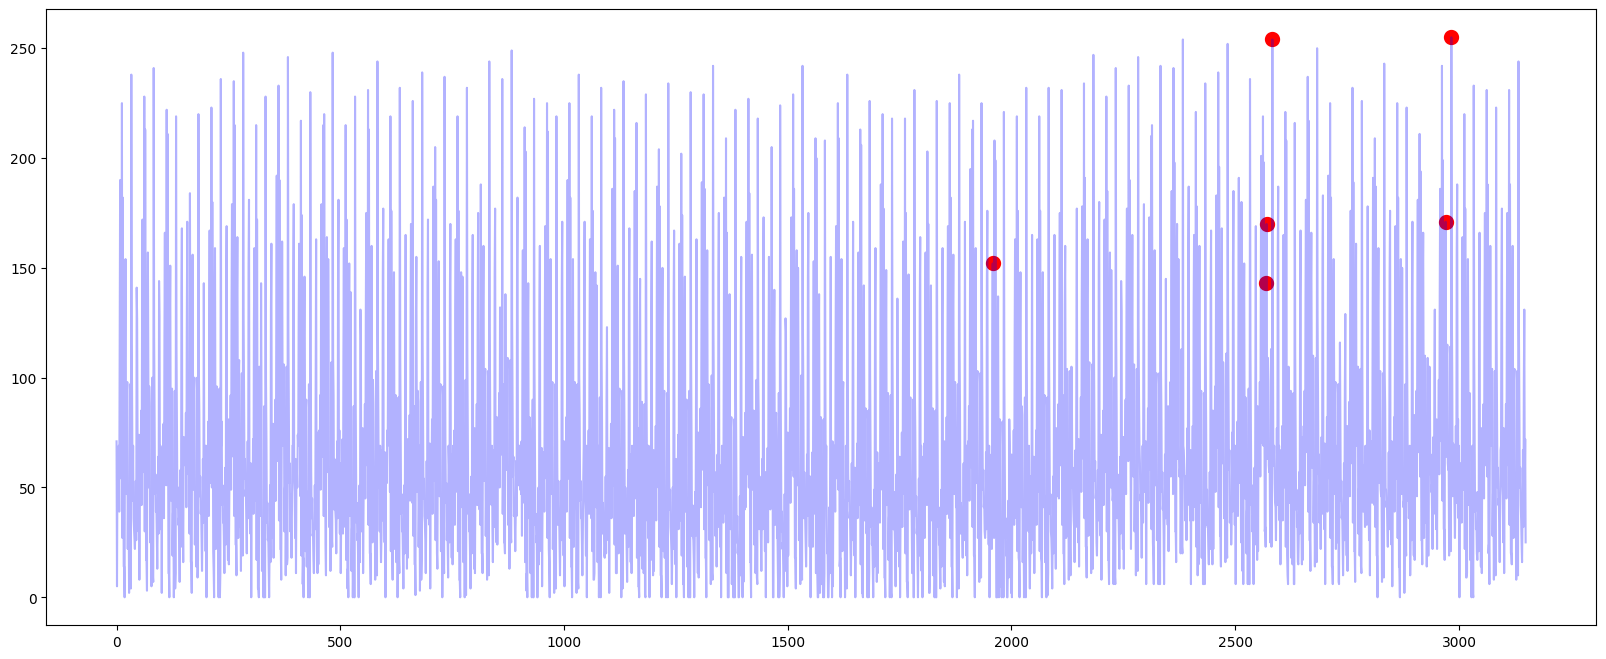

In [25]:
plt.figure(figsize=(20,8))
plt.plot(df.index,df["Frequency of use"] ,color = "b",alpha = 0.3)
plt.scatter(otlr_val.index,otlr_val["Frequency of use"], color='r',linewidths=5)

In [26]:
model=IsolationForest(n_estimators=1000,
                      max_samples='auto',
                      contamination=float(0.2),
                      max_features=1.0)
model.fit(df[["Frequency of use"]])

IsolationForest(contamination=0.2, n_estimators=1000)

In [27]:
df2 = df.copy()

In [28]:
df2['scores']=model.decision_function(df2[['Frequency of use']])
df2['anomaly']=model.predict(df[['Frequency of use']])
df2.head(20)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn,scores,anomaly
0,8,0,38,0,4370,71,5,17,0,0.071699,1
1,0,0,32,0,318,5,7,4,0,-0.025422,-1
2,10,0,37,0,2453,60,359,24,0,0.068639,1
3,10,0,38,0,4198,66,73,35,0,0.072223,1
4,3,0,38,0,4457,58,73,33,0,0.065024,1
5,11,0,32,1,4457,69,73,28,0,0.115403,1
6,4,0,38,0,2360,39,285,18,0,0.081879,1
7,13,0,37,2,4457,121,73,43,0,0.001147,1
8,4,0,38,0,13773,190,73,44,0,-0.073131,-1
9,7,0,32,1,4457,83,2,25,0,0.059137,1


In [49]:
df2[(df2['Churn']==1) & (df2['anomaly']==-1)].shape

(51, 11)

In [29]:
df2[df2['anomaly']== -1]

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn,scores,anomaly
1,0,0,32,0,318,5,7,4,0,-0.025422,-1
8,4,0,38,0,13773,190,73,44,0,-0.073131,-1
12,25,0,32,3,15140,225,54,32,0,-0.102162,-1
14,9,0,37,0,4457,182,150,30,0,-0.046083,-1
20,7,0,37,1,11465,154,11,47,0,-0.026974,-1
...,...,...,...,...,...,...,...,...,...,...,...
3112,30,0,40,4,4457,231,61,60,0,-0.113400,-1
3114,14,0,39,1,4457,188,157,32,0,-0.063747,-1
3120,12,0,39,2,11770,160,18,49,0,-0.029614,-1
3133,30,0,33,4,16380,244,73,82,0,-0.177873,-1


In [30]:
df2[df2['anomaly']== -1].shape[0]/df.shape[0]*100

19.904761904761905

In [31]:
df3 = df.copy()

In [32]:
model=IsolationForest(n_estimators=1000,
                      max_samples='auto',
                      contamination=float(0.2),
                      max_features=9)
model.fit(df)

IsolationForest(contamination=0.2, max_features=9, n_estimators=1000)

In [33]:
df3['scores']=model.decision_function(df)
df3['anomaly']=model.predict(df)
df3.head(20)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn,scores,anomaly
0,8,0,38,0,4370,71,5,17,0,0.129178,1
1,0,0,32,0,318,5,7,4,0,0.099390,1
2,10,0,37,0,2453,60,359,24,0,0.053763,1
3,10,0,38,0,4198,66,73,35,0,0.120923,1
4,3,0,38,0,4457,58,73,33,0,0.123152,1
5,11,0,32,1,4457,69,73,28,0,0.128872,1
6,4,0,38,0,2360,39,285,18,0,0.081962,1
7,13,0,37,2,4457,121,73,43,0,0.093473,1
8,4,0,38,0,13773,190,73,44,0,0.012588,1
9,7,0,32,1,4457,83,2,25,0,0.129150,1


In [34]:
df3[df3['anomaly']== -1]

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn,scores,anomaly
12,25,0,32,3,15140,225,54,32,0,-0.048003,-1
22,4,1,33,0,955,47,73,17,1,-0.041575,-1
23,23,1,32,8,10435,93,1,28,0,-0.140761,-1
24,13,1,36,1,5818,98,26,24,1,-0.088492,-1
31,0,1,36,0,628,7,9,4,1,-0.051135,-1
...,...,...,...,...,...,...,...,...,...,...,...
3122,4,1,35,0,1260,27,23,19,1,-0.026189,-1
3123,26,0,38,9,4457,99,8,30,0,-0.061808,-1
3131,5,1,38,0,933,13,16,10,1,-0.036282,-1
3133,30,0,33,4,16380,244,73,82,0,-0.128969,-1


In [35]:
df3[df3['anomaly']== -1].shape[0]/df.shape[0]*100

20.0

In [50]:
df3[(df3['Churn']==1) & (df3['anomaly']==-1)].shape

(268, 11)

In [46]:
model2=IsolationForest(n_estimators=1000,
                      max_samples='auto',
                      max_features=9)
model2.fit(df)
df3['scores']=model2.decision_function(df)
df3['anomaly']=model2.predict(df)
display(df3.head(20))
df3[df3['anomaly']== -1].shape[0]/df.shape[0]*100

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn,scores,anomaly
0,8,0,38,0,4370,71,5,17,0,0.121331,1
1,0,0,32,0,318,5,7,4,0,0.089595,1
2,10,0,37,0,2453,60,359,24,0,0.042146,1
3,10,0,38,0,4198,66,73,35,0,0.112454,1
4,3,0,38,0,4457,58,73,33,0,0.114641,1
5,11,0,32,1,4457,69,73,28,0,0.120196,1
6,4,0,38,0,2360,39,285,18,0,0.073817,1
7,13,0,37,2,4457,121,73,43,0,0.084166,1
8,4,0,38,0,13773,190,73,44,0,0.003910,1
9,7,0,32,1,4457,83,2,25,0,0.120262,1


22.253968253968253

In [36]:
X = df.values

In [53]:
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn
0,8,0,38,0,4370,71,5,17,0
1,0,0,32,0,318,5,7,4,0
2,10,0,37,0,2453,60,359,24,0
3,10,0,38,0,4198,66,73,35,0
4,3,0,38,0,4457,58,73,33,0


In [37]:
dbscan = DBSCAN(eps = 100, min_samples= 4)

In [38]:
db_model = dbscan.fit(X)

In [39]:
labels = db_model.labels_

In [40]:
len(labels)

3150

In [41]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8], dtype=int64)

In [42]:
pd.value_counts(labels)

 0    2298
 2     395
 3     143
 4      98
 5      90
-1      53
 1      46
 6      14
 7       7
 8       6
Name: count, dtype: int64

In [43]:
df[labels == -1]

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Churn
457,17,0,37,4,9715,137,165,58,0
463,8,0,32,3,3695,37,504,23,0
513,0,0,38,0,2495,17,462,7,0
523,17,0,32,6,9835,139,0,27,0
538,0,0,27,0,715,26,172,1,0
546,8,0,15,0,8333,119,52,25,0
856,10,0,39,1,3070,50,293,18,0
863,11,0,39,2,3805,38,491,8,0
869,9,0,38,1,8218,138,73,39,0
887,12,0,32,1,3490,64,183,22,0


In [44]:
sum(labels == -1)/df.shape[0]*100

1.6825396825396828